# MNIST Multilayer Perceptron

## Code setup

In [1]:
# Suppressing warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Utility imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import gc

# Source imports
from plotting import training_validation_plotter, accuracy_curves_plotter
from weight_alterations import cannot_electroform
from mlp_generator import two_layers
from mlp_trainer import dataset_creation, train_MLP

In [3]:
# Importing LaTeX font for plots
os.system('wget -O cmunrm.ttf https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf > /dev/null 2>&1')

#!wget -O cmunrm.ttf https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf

fpath = Path('cmunrm.ttf')
font = fm.FontProperties(fname='cmunrm.ttf', size=18)

## Neural network setup and training

This is the network architecture employed in the *Simulation of Inference Accuracy Using Realistic RRAM Devices* paper. It consists of a feed-forward multilayer perceptron with 784 input neurons (encoding pixel intensities for 28 × 28 pixel MNIST images), two 100-neuron hidden layers, and 10 output neurons (each corresponding to one of the ten digits). The first three layers employ a sigmoid activation function, whilst the output layer makes use of a softmax activation function (which means a cross-entropy error function is then used throughout the learning task). All 60,000 MNIST training images were employed, divided into training and validation sets in a 3:1 ratio, as described in the aforementioned paper.

In [4]:
# Create dataset and results lists
MNIST_dataset = dataset_creation()

weights_list = []
histories_list = []

number_of_ANNs = 30

# Model definition and training, repeated 30 times to average out stochastic variancies
for model_number in range(0, number_of_ANNs):

    MNIST_MLP = two_layers()
    MLP_weights, MLP_history, *_ = train_MLP(MNIST_dataset, MNIST_MLP, epochs=10, batch_size=100)
    weights_list.append(MLP_weights)
    histories_list.append(MLP_history)
    
    print("Model #{} finished training.".format(model_number+1))
    gc.collect()

11493376/11490434 [==============================] - 0s 0us/step
Model #1 finished training.
Model #2 finished training.
Model #3 finished training.
Model #4 finished training.
Model #5 finished training.
Model #6 finished training.
Model #7 finished training.
Model #8 finished training.
Model #9 finished training.
Model #10 finished training.
Model #11 finished training.
Model #12 finished training.
Model #13 finished training.
Model #14 finished training.
Model #15 finished training.
Model #16 finished training.
Model #17 finished training.
Model #18 finished training.
Model #19 finished training.
Model #20 finished training.
Model #21 finished training.
Model #22 finished training.
Model #23 finished training.
Model #24 finished training.
Model #25 finished training.
Model #26 finished training.
Model #27 finished training.
Model #28 finished training.
Model #29 finished training.
Model #30 finished training.


## Performance evolution during training

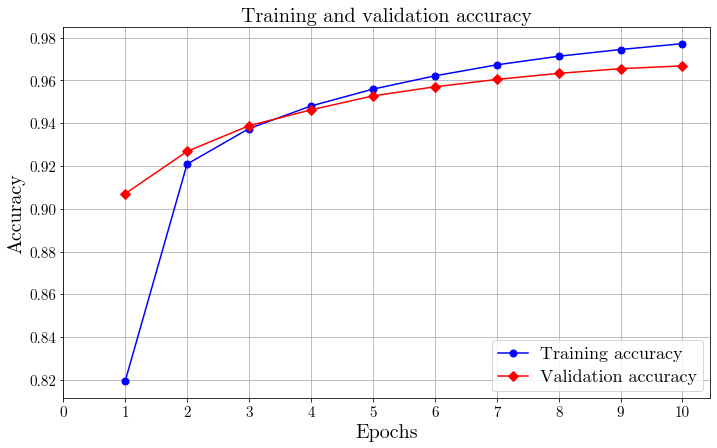

In [5]:
# Plotting training and validation accuracy by averaging over all the models trained in the previous step

epochs = range(1, len(histories_list[0].history["accuracy"]) + 1)
accuracy_values = np.zeros(len(histories_list[0].history["accuracy"]))
validation_accuracy_values = np.zeros(len(histories_list[0].history["accuracy"]))

for MLP_history in histories_list:

    history_dict = MLP_history.history
    accuracy_values += np.array(history_dict["accuracy"])
    validation_accuracy_values += np.array(history_dict["val_accuracy"])

accuracy_values /= len(histories_list)
validation_accuracy_values /= len(histories_list)

training_validation_plotter(epochs, accuracy_values, validation_accuracy_values, "Accuracy", font)

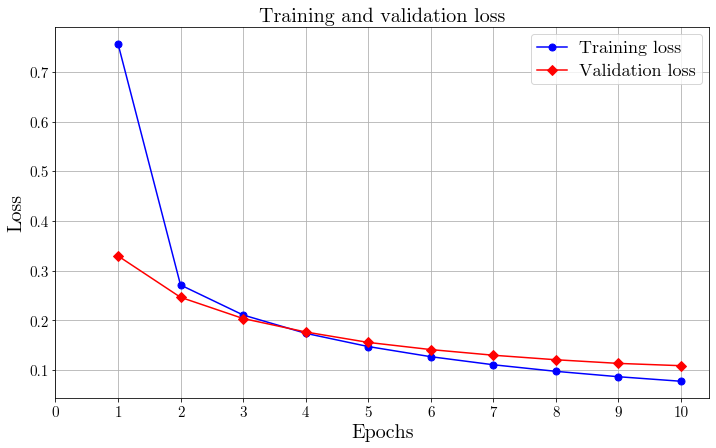

In [6]:
# Plotting training and validation loss by averaging over all the models trained in the previous step

loss_values = np.zeros(len(histories_list[0].history["accuracy"]))
validation_loss_values = np.zeros(len(histories_list[0].history["accuracy"]))

for MLP_history in histories_list:

    history_dict = MLP_history.history
    loss_values += np.array(history_dict["loss"])
    validation_loss_values += np.array(history_dict["val_loss"])

loss_values /= len(histories_list)
validation_loss_values /= len(histories_list)

training_validation_plotter(epochs, loss_values, validation_loss_values, "Loss", font)

## Type I Fault: Cannot electroform

Finished evaluating weight set #1.
Finished evaluating weight set #2.
Finished evaluating weight set #3.
Finished evaluating weight set #4.
Finished evaluating weight set #5.
Finished evaluating weight set #6.
Finished evaluating weight set #7.
Finished evaluating weight set #8.
Finished evaluating weight set #9.
Finished evaluating weight set #10.
Finished evaluating weight set #11.
Finished evaluating weight set #12.
Finished evaluating weight set #13.
Finished evaluating weight set #14.
Finished evaluating weight set #15.
Finished evaluating weight set #16.
Finished evaluating weight set #17.
Finished evaluating weight set #18.
Finished evaluating weight set #19.
Finished evaluating weight set #20.
Finished evaluating weight set #21.
Finished evaluating weight set #22.
Finished evaluating weight set #23.
Finished evaluating weight set #24.
Finished evaluating weight set #25.
Finished evaluating weight set #26.
Finished evaluating weight set #27.
Finished evaluating weight set #28.
F

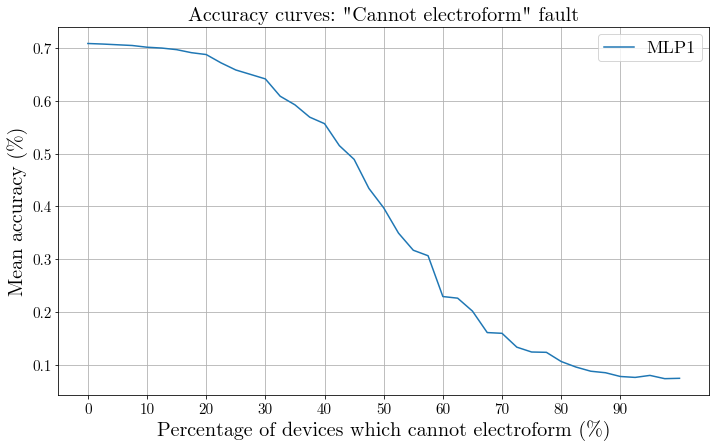

In [7]:
# Setting variable percentages of the ANN's synaptic weights to zero in order to simulate devices being unable to electroform

percentages = np.arange(0, 1.01, 0.025)
accuracies = np.zeros(len(percentages))

MNIST_MLP = two_layers()
MNIST_MLP.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

for count, weights in enumerate(weights_list):

    accuracies_list = []

    for percentage in percentages:

        altered_weights = cannot_electroform(weights, percentage)
        
        # The "set_weights" function sets the ANN's weights to the values specified in the list of arrays "altered_weights"
        MNIST_MLP.set_weights(altered_weights)
        accuracies_list.append(MNIST_MLP.evaluate(MNIST_dataset[1][0], MNIST_dataset[1][1], verbose=0)[1])

    accuracies += np.array(accuracies_list)

    print("Finished evaluating weight set #{}.".format(count+1))
    gc.collect()

accuracies /= len(percentages)

accuracy_curves_plotter(percentages, [accuracies], value_type=1, fpath=font, labels=["MLP1"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f63981ff-15e3-4a0a-8bcf-dbdeefafcfde' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>